In [1]:
import pandas as pd
import os
import time
import re
from pathlib import Path

In [2]:
import pandasai as pai
from pandasai_litellm.litellm import LiteLLM
from litellm import completion


In [3]:
# # Initialize LiteLLM with your OpenAI model
# # llm = LiteLLM(model='ollama/qwen3:8b',api_base="http://localhost:11434", stream=False)
# # llm = LiteLLM(model='ollama/llama3:latest',api_base="http://localhost:11434", stream=False)
# llm = LiteLLM(model="nvidia_nim/google/gemma-2-27b-it", api_key="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", stream=False)
# llm = LiteLLM(
#     model="nvidia_nim/meta/llama3-70b-instruct",
#     api_key="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",
#     stream=False,
# )
# llm = LiteLLM(
#     model="nvidia_nim/deepseek/deepseek-r1",
#     api_key="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",
#     stream=False,
# )
# llm = LiteLLM(
#     model="nvidia_nim/meta/llama-3.1-8b-instruct",
#     api_key="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",
#     stream=False,
# )
# llm = LiteLLM(
#     model="nvidia_nim/mistralai/mistral-nemo-12b-instruct",
#     api_key="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",
#     stream=False,
# )

# CHARTS_DIR = "exports/charts_deepseek"
# # os.makedirs(CHARTS_DIR, exist_ok=True)

# config = {
#     "llm": llm,
#     "save_charts": True,
#     "save_charts_path": CHARTS_DIR,
# }
# pai.config.set(config)

In [4]:


df_clinic_level = pd.read_csv("cc_clinic_level.csv")
df_doctor = pd.read_csv("cc_doctor.csv")
df_hourly = pd.read_csv("cc_hourly.csv")
df_patient = pd.read_csv("cc_patient.csv")

df_clinic_level = pai.DataFrame(df_clinic_level)
df_doctor = pai.DataFrame(df_doctor)
df_hourly = pai.DataFrame(df_hourly)
df_patient = pai.DataFrame(df_patient)



In [5]:
# Define questions by difficulty level (5 each = 15 total)
easy_questions = [
    "Show the first 5 rows of the clinic level data.",
    "Which clinic has the highest TotalRevenue?",
    "What is the average TotalRevenue across all clinics?",
    "List all unique Districts present in the dataset.",
    "How many doctors are listed in the doctor dataset?",
]

medium_questions = [
    "Group the patient records by Religion and count how many patients are in each group.",
    "Calculate the total revenue per District.",
    "Find the average TotalRevenue for doctors who are 'Locum' vs 'Residence'.",
    "Which hour of the day has the highest average TotalRevenue?",
    "Compare the total number of Cash payments vs Electronic payments.",
]

hard_questions = [
    "Calculate the average revenue per patient (TotalRevenue / TotalPatientCount) for each clinic and show the top 3 clinics.",
    "Identify which District has the highest proportion of 'NewPatientCount' compared to 'PatientCount'.",
    "Filter for doctors who have worked more than 100 hours but generated less than 50,000 in TotalRevenue.",
    "Is there any correlation between the number of 'TotalPanelPatientCount' and 'TotalRevenue'?",
    "Which clinic has the highest number of Muslims?",
]

# Define model to test 
models_to_test = [
    ("nvidia_nim/meta/llama-3.1-8b-instruct", "Llama-3.1-8B"),
    ("nvidia_nim/qwen/qwen2.5-7b-instruct", "qwen2.5-7b-instruct"),
    ("nvidia_nim/google/gemma-2-27b-it", "Gemma-2-27B"),
    ("nvidia_nim/meta/llama3-70b-instruct", "Llama3-70B"),
    ("nvidia_nim/deepseek-ai/deepseek-r1", "deepseek-r1"),
]

# Number of times to run each question
NUM_RUNS = 3

# File path for saving results incrementally
RESULTS_FILE = "exports/benchmark_results.csv"
os.makedirs("exports", exist_ok=True)

# Load existing results if resuming
if os.path.exists(RESULTS_FILE) and os.path.getsize(RESULTS_FILE) > 0:
    try:
        results_df = pd.read_csv(RESULTS_FILE)
        results = results_df.to_dict('records')
        print(f"📂 Loaded {len(results)} existing results from {RESULTS_FILE}")
    except pd.errors.EmptyDataError:
        results = []
        print("📂 Results file was empty, starting fresh benchmark")
else:
    results = []
    print("📂 Starting fresh benchmark")

def get_completed_tests(results):
    """Get set of (model, difficulty, question, run_num) tuples already completed"""
    return {(r['model'], r['difficulty'], r['question'], r.get('run_num', 1)) for r in results}

def save_results(results):
    """Save results to CSV file"""
    df = pd.DataFrame(results)
    df.to_csv(RESULTS_FILE, index=False)
    print(f"💾 Saved {len(results)} results to {RESULTS_FILE}")

def run_test(model_id, model_name, question, difficulty, dataframes, run_num, max_retries=2):
    """Run a single test with retry logic"""
    for attempt in range(max_retries + 1):
        try:
            # Configure the LLM
            llm = LiteLLM(
                model=model_id,
                api_key="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",
                stream=False,
            )
            pai.config.set({"llm": llm, "save_charts": False})
            
            start_time = time.time()
            response = pai.chat(question, *dataframes)
            elapsed_time = time.time() - start_time
            
            # Extract SQL query from log
            log_path = Path("pandasai.log")
            sql_query = ""
            is_correct = None
            
            if log_path.exists():
                text = log_path.read_text(encoding="utf-8")
                
                # Try different patterns
                multi_line_pattern = r'sql_query\s*=\s*"""(.+?)"""'
                single_quote_pattern = r"sql_query\s*=\s*'([^']+)'"
                double_quote_pattern = r'sql_query\s*=\s*"([^"]+)"'
                
                matches = re.findall(multi_line_pattern, text, re.DOTALL)
                if not matches:
                    matches = re.findall(single_quote_pattern, text)
                if not matches:
                    matches = re.findall(double_quote_pattern, text)
                
                if matches:
                    sql_query = matches[-1].strip()
                    
                    # Validate with LLM (with its own error handling)
                    try:
                        validation = completion(
                            model="nvidia_nim/google/gemma-2-27b-it",
                            messages=[{"role": "user", "content": f"You just answer me true or false do not explain: does this query: {sql_query} correctly answer the question: {question}"}],
                            api_key="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",
                        )
                        is_correct = "true" in validation.choices[0].message.content.lower()
                    except Exception as val_err:
                        print(f"      ⚠️ Validation error: {val_err}")
                        is_correct = None  # Unknown if correct
                
                # Clear log
                log_path.write_text("", encoding="utf-8")
            
            return {
                "model": model_name,
                "difficulty": difficulty,
                "question": question,
                "run_num": run_num,
                "response": str(response.value) if hasattr(response, 'value') else str(response),
                "sql_query": sql_query,
                "is_correct": is_correct,
                "time_seconds": elapsed_time,
                "success": True,
                "error": None,
                "attempt": attempt + 1
            }
            
        except Exception as e:
            if attempt < max_retries:
                print(f"      ⚠️ Attempt {attempt + 1} failed, retrying... ({str(e)[:50]})")
                time.sleep(2)  # Wait before retry
            else:
                return {
                    "model": model_name,
                    "difficulty": difficulty,
                    "question": question,
                    "run_num": run_num,
                    "response": None,
                    "sql_query": None,
                    "is_correct": False,
                    "time_seconds": None,
                    "success": False,
                    "error": str(e)[:200],  # Truncate long errors
                    "attempt": attempt + 1
                }

# Run the benchmark with error handling
print("\n" + "=" * 80)
print(f"🚀 Starting benchmark: 5 models × 15 questions × {NUM_RUNS} runs = {5 * 15 * NUM_RUNS} tests")
print("=" * 80)

difficulty_map = {
    "Easy": (easy_questions, [df_clinic_level]),
    "Medium": (medium_questions, [df_clinic_level, df_doctor, df_hourly]),
    "Hard": (hard_questions, [df_clinic_level, df_doctor, df_hourly, df_patient]),
}

completed_tests = get_completed_tests(results)
total_tests = len(models_to_test) * 3 * 5 * NUM_RUNS  # 5 models * 3 difficulties * 5 questions * 3 runs = 225
tests_run = len(completed_tests)

try:
    for run_num in range(1, NUM_RUNS + 1):  # Run 1, 2, 3
        print(f"\n{'='*80}")
        print(f"🔄 RUN {run_num} of {NUM_RUNS}")
        print(f"{'='*80}")
        
        for model_id, model_name in models_to_test:
            print(f"\n🔧 Testing Model: {model_name}")
            print("-" * 40)
            
            for difficulty, (questions, dataframes) in difficulty_map.items():
                print(f"\n  📊 Difficulty: {difficulty}")
                
                for q_idx, question in enumerate(questions[:5]):
                    # Skip if already completed (includes run_num)
                    if (model_name, difficulty, question, run_num) in completed_tests:
                        print(f"    ⏭️ Q{q_idx+1} Run{run_num}: Already completed, skipping...")
                        continue
                    
                    print(f"    Q{q_idx+1} (Run {run_num}): {question[:40]}...")
                    
                    result = run_test(model_id, model_name, question, difficulty, dataframes, run_num)
                    results.append(result)
                    tests_run += 1
                    
                    status = "✅" if result["success"] and result["is_correct"] else "❌" if result["success"] else "💥"
                    time_str = f"{result['time_seconds']:.2f}s" if result['time_seconds'] else "N/A"
                    print(f"      {status} Time: {time_str} | Progress: {tests_run}/{total_tests}")
                    
                    # Save after each test to preserve progress
                    save_results(results)

except KeyboardInterrupt:
    print("\n\n⚠️ Benchmark interrupted by user!")
    print("💾 Saving partial results...")
    save_results(results)
    print("You can resume by running this cell again.")

except Exception as e:
    print(f"\n\n❌ Unexpected error: {e}")
    print("💾 Saving partial results...")
    save_results(results)
    print("You can resume by running this cell again.")

print("\n" + "=" * 80)
print(f"✅ Benchmark complete! Total results: {len(results)}")
print("=" * 80)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(f"\nResults saved to: {RESULTS_FILE}")
results_df.head(10)

📂 Starting fresh benchmark

🚀 Starting benchmark: 5 models × 15 questions × 3 runs = 225 tests

🔄 RUN 1 of 3

🔧 Testing Model: Llama-3.1-8B
----------------------------------------

  📊 Difficulty: Easy
    Q1 (Run 1): Show the first 5 rows of the clinic leve...
      ✅ Time: 39.44s | Progress: 1/225
💾 Saved 1 results to exports/benchmark_results.csv
    Q2 (Run 1): Which clinic has the highest TotalRevenu...
{'type': 'string', 'value': 'The clinic with the highest TotalRevenue is Clinic I with a revenue of 3487368.95.'}
      ✅ Time: 2.07s | Progress: 2/225
💾 Saved 2 results to exports/benchmark_results.csv
    Q3 (Run 1): What is the average TotalRevenue across ...
{'type': 'number', 'value': 1220906.65}
      ❌ Time: 3.70s | Progress: 3/225
💾 Saved 3 results to exports/benchmark_results.csv
    Q4 (Run 1): List all unique Districts present in the...
{'type': 'dataframe', 'value':          District
0   Petaling Jaya
1           Bangi
2    Kuala Langat
3       Presint 8
4     Bayan Le

: 

: 

📊 Analyzing 127 test results...

📊 Summary Statistics by Model and Difficulty


C:\Users\User\AppData\Local\Temp\ipykernel_22468\1535527455.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df['is_correct'] = results_df['is_correct'].fillna(False)


,model,difficulty,correct_count,total_count,accuracy,avg_time,time_std,success_rate
0,Gemma-2-27B,Easy,4,5,0.800,5.503,3.810,1.0
1,Gemma-2-27B,Hard,4,5,0.800,19.539,19.822,1.0
2,Gemma-2-27B,Medium,3,5,0.600,10.133,11.790,1.0
3,Llama-3.1-8B,Easy,14,25,0.560,5.592,10.142,1.0
4,Llama-3.1-8B,Hard,5,20,0.250,7.101,6.322,1.0
5,Llama-3.1-8B,Medium,9,22,0.409,12.411,39.117,1.0
6,Llama3-70B,Easy,3,5,0.600,6.860,2.020,1.0
7,Llama3-70B,Hard,5,5,1.000,12.102,3.661,1.0
8,Llama3-70B,Medium,4,5,0.800,10.920,3.916,1.0
9,deepseek-r1,Easy,3,5,0.600,23.321,29.799,1.0



📈 Overall Model Performance (Ranked by Accuracy)


,accuracy,avg_time_seconds,success_rate
model,,,
Llama3-70B,0.800,9.961,1.0
deepseek-r1,0.800,18.271,1.0
Gemma-2-27B,0.733,11.725,1.0
qwen2.5-7b-instruct,0.533,10.970,1.0
Llama-3.1-8B,0.418,8.281,1.0


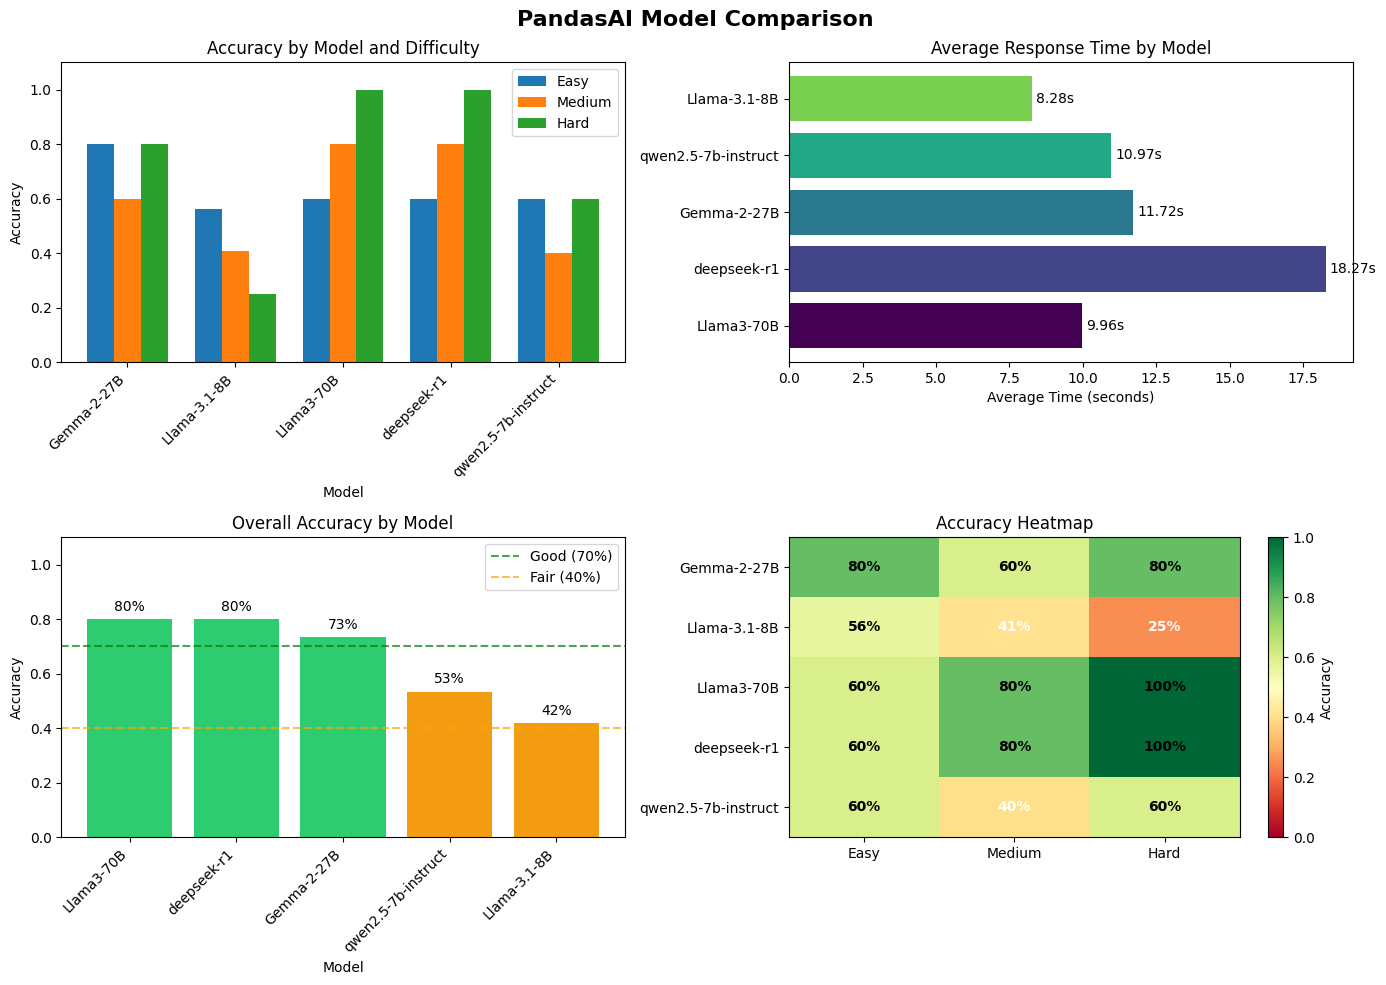


🏆 BEST MODEL RECOMMENDATION

✅ Best Model: Llama3-70B
   - Overall Accuracy: 80.0%
   - Average Response Time: 9.96 seconds

   Performance by Difficulty:
     • Easy: 60.0% accuracy (3/5)
     • Hard: 100.0% accuracy (5/5)
     • Medium: 80.0% accuracy (4/5)

🥈 Runner-up: deepseek-r1 (80.0% accuracy)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load results from file (in case running separately)
if 'results_df' not in dir() or results_df is None or len(results_df) == 0:
    if os.path.exists(RESULTS_FILE):
        results_df = pd.read_csv(RESULTS_FILE)
        print(f"📂 Loaded {len(results_df)} results from {RESULTS_FILE}")
    else:
        raise ValueError("No results found! Run the benchmark cell first.")

# Check if we have enough data
if len(results_df) == 0:
    raise ValueError("No results to visualize!")

print(f"📊 Analyzing {len(results_df)} test results...")

# Handle missing/null values for visualization
results_df['is_correct'] = results_df['is_correct'].fillna(False)
results_df['time_seconds'] = pd.to_numeric(results_df['time_seconds'], errors='coerce')

# Create summary statistics
summary = results_df.groupby(['model', 'difficulty']).agg({
    'is_correct': ['sum', 'count', 'mean'],
    'time_seconds': ['mean', 'std'],
    'success': 'mean'
}).round(3)

summary.columns = ['correct_count', 'total_count', 'accuracy', 'avg_time', 'time_std', 'success_rate']
summary = summary.reset_index()

print("\n📊 Summary Statistics by Model and Difficulty")
print("=" * 80)
display(summary)

# Overall model performance
model_summary = results_df.groupby('model').agg({
    'is_correct': 'mean',
    'time_seconds': 'mean',
    'success': 'mean'
}).round(3)
model_summary.columns = ['accuracy', 'avg_time_seconds', 'success_rate']
model_summary = model_summary.sort_values('accuracy', ascending=False)

print("\n📈 Overall Model Performance (Ranked by Accuracy)")
print("=" * 80)
display(model_summary)

# Show error summary if any failures
failed_tests = results_df[results_df['success'] == False]
if len(failed_tests) > 0:
    print(f"\n⚠️ {len(failed_tests)} tests failed:")
    print(failed_tests[['model', 'difficulty', 'error']].head(10))

# Create visualizations (only if we have data for at least 1 model)
if len(model_summary) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('PandasAI Model Comparison', fontsize=16, fontweight='bold')

    # 1. Accuracy by Model and Difficulty (Grouped Bar Chart)
    ax1 = axes[0, 0]
    difficulties = ['Easy', 'Medium', 'Hard']
    models = summary['model'].unique()
    x = np.arange(len(models))
    width = 0.25

    for i, diff in enumerate(difficulties):
        diff_data = summary[summary['difficulty'] == diff]
        accuracies = []
        for m in models:
            model_diff_data = diff_data[diff_data['model'] == m]
            if len(model_diff_data) > 0:
                accuracies.append(model_diff_data['accuracy'].values[0])
            else:
                accuracies.append(0)
        ax1.bar(x + i*width, accuracies, width, label=diff)

    ax1.set_xlabel('Model')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy by Model and Difficulty')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(models, rotation=45, ha='right')
    ax1.legend()
    ax1.set_ylim(0, 1.1)

    # 2. Average Response Time by Model
    ax2 = axes[0, 1]
    valid_times = model_summary['avg_time_seconds'].dropna()
    if len(valid_times) > 0:
        colors = plt.cm.viridis(np.linspace(0, 0.8, len(valid_times)))
        bars = ax2.barh(valid_times.index, valid_times.values, color=colors)
        ax2.set_xlabel('Average Time (seconds)')
        ax2.set_title('Average Response Time by Model')
        ax2.bar_label(bars, fmt='%.2fs', padding=3)
    else:
        ax2.text(0.5, 0.5, 'No timing data available', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Average Response Time by Model')

    # 3. Overall Accuracy Comparison
    ax3 = axes[1, 0]
    colors = ['#2ecc71' if acc >= 0.7 else '#f39c12' if acc >= 0.4 else '#e74c3c' for acc in model_summary['accuracy']]
    bars = ax3.bar(model_summary.index, model_summary['accuracy'], color=colors)
    ax3.set_xlabel('Model')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Overall Accuracy by Model')
    ax3.set_ylim(0, 1.1)
    ax3.axhline(y=0.7, color='green', linestyle='--', alpha=0.7, label='Good (70%)')
    ax3.axhline(y=0.4, color='orange', linestyle='--', alpha=0.7, label='Fair (40%)')
    ax3.legend()
    for bar, acc in zip(bars, model_summary['accuracy']):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{acc:.0%}', ha='center', va='bottom', fontsize=10)
    plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

    # 4. Success Rate Heatmap
    ax4 = axes[1, 1]
    try:
        pivot_data = summary.pivot(index='model', columns='difficulty', values='accuracy')
        # Reorder columns if they exist
        cols_order = [c for c in ['Easy', 'Medium', 'Hard'] if c in pivot_data.columns]
        pivot_data = pivot_data[cols_order]
        
        im = ax4.imshow(pivot_data.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        ax4.set_xticks(np.arange(len(pivot_data.columns)))
        ax4.set_yticks(np.arange(len(pivot_data.index)))
        ax4.set_xticklabels(pivot_data.columns)
        ax4.set_yticklabels(pivot_data.index)
        ax4.set_title('Accuracy Heatmap')
        
        # Add text annotations
        for i in range(len(pivot_data.index)):
            for j in range(len(pivot_data.columns)):
                val = pivot_data.values[i, j]
                if not np.isnan(val):
                    ax4.text(j, i, f'{val:.0%}', ha='center', va='center', 
                            color='white' if val < 0.5 else 'black', fontweight='bold')
        
        plt.colorbar(im, ax=ax4, label='Accuracy')
    except Exception as e:
        ax4.text(0.5, 0.5, f'Not enough data for heatmap\n{str(e)[:50]}', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Accuracy Heatmap')

    plt.tight_layout()
    os.makedirs('exports/charts', exist_ok=True)
    plt.savefig('exports/charts/model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Final Recommendation
    print("\n" + "=" * 80)
    print("🏆 BEST MODEL RECOMMENDATION")
    print("=" * 80)
    
    best_model = model_summary['accuracy'].idxmax()
    best_accuracy = model_summary.loc[best_model, 'accuracy']
    best_time = model_summary.loc[best_model, 'avg_time_seconds']

    print(f"\n✅ Best Model: {best_model}")
    print(f"   - Overall Accuracy: {best_accuracy:.1%}")
    if pd.notna(best_time):
        print(f"   - Average Response Time: {best_time:.2f} seconds")

    # Show performance by difficulty for best model
    best_model_details = summary[summary['model'] == best_model]
    if len(best_model_details) > 0:
        print(f"\n   Performance by Difficulty:")
        for _, row in best_model_details.iterrows():
            print(f"     • {row['difficulty']}: {row['accuracy']:.1%} accuracy ({row['correct_count']:.0f}/{row['total_count']:.0f})")
    
    # Also show runner-up for comparison
    if len(model_summary) > 1:
        runner_up = model_summary['accuracy'].nlargest(2).index[-1]
        runner_accuracy = model_summary.loc[runner_up, 'accuracy']
        print(f"\n🥈 Runner-up: {runner_up} ({runner_accuracy:.1%} accuracy)")

else:
    print("❌ No model data available for visualization")

In [ ]:
# import time

# #easy question
# for i in range(1,2):
#     question="Which clinic have most patient?"
#     start_time = time.time()
#     response=pai.chat(question,df_clinic_level)
#     print(llm.model)
#     print(response.value)

#     # Extract SQL query from log (handles both single-line and multi-line queries)
#     log_path = Path("pandasai.log")
#     text = log_path.read_text(encoding="utf-8")

#     # Pattern for triple-quoted multi-line SQL
#     multi_line_pattern = r'sql_query\s*=\s*"""(.+?)"""'
#     # Pattern for single-quoted SQL
#     single_quote_pattern = r"sql_query\s*=\s*'([^']+)'"
#     # Pattern for double-quoted SQL
#     double_quote_pattern = r'sql_query\s*=\s*"([^"]+)"'

#     # Try multi-line first, then single/double quotes
#     matches = re.findall(multi_line_pattern, text, re.DOTALL)
#     if not matches:
#         matches = re.findall(single_quote_pattern, text)
#     if not matches:
#         matches = re.findall(double_quote_pattern, text)

#     if not matches:
#         raise ValueError("No sql_query found in log")

#     sql_query = matches[-1].strip()  # take the latest one and clean whitespace
#     print("Extracted SQL:", sql_query)

#     # Clear the log after extraction
#     log_path.write_text("", encoding="utf-8")

#     response = completion(
#         model="nvidia_nim/google/gemma-2-27b-it",
#         messages=[{"role": "user", "content": f"You just answer me true or false do not explain: do my query:{sql_query} is match the question:{question}"}],
#         api_key="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",
#     )
#     print(response.choices[0].message.content)
#     elapsed_time = time.time() - start_time
#     print(f"Time taken: {elapsed_time:.2f} seconds")
#     print("\n")

# # # medium question
# # for i in range(16,26):
# #     start_time = time.time()
# #     print(f"test {i} ")
# #     response=pai.chat("Which clinic have most patient?",df_clinic_level)
# #     print(llm.model)
# #     print(response.value)
# #     elapsed_time = time.time() - start_time
# #     print(f"Time taken: {elapsed_time:.2f} seconds")
# #     print("\n")

# # #hard question
# for i in range(19,26):
#     start_time = time.time()
#     print(f"test {i} ")
#     response=pai.chat("Which clinic has the highest number of Muslims?",df_clinic_level,df_patient)
#     print(llm.model)
#     print(response.value)
#     elapsed_time = time.time() - start_time
#     print(f"Time taken: {elapsed_time:.2f} seconds")
#     print("\n")

nvidia_nim/google/gemma-2-27b-it
The clinic with the most patients is Clinic D.
Extracted SQL: SELECT IDOrganisation, PatientCount
FROM table_bd4f8d5ffa8239c09831e5b997bc2753
ORDER BY PatientCount DESC
LIMIT 1
True.

Time taken: 8.29 seconds


